In [2]:
%matplotlib inline

In [3]:
import numpy as np

In [4]:
import matplotlib.image as mpimg

In [5]:
import matplotlib.pyplot as plt

In [6]:
import matplotlib.cm as cm

In [7]:
import png

In [52]:
import scipy.ndimage as ndimage

In [36]:
height, width = 100,100

In [37]:
# Step 1. Generate a grid of random unit vectors.
img = np.random.uniform(0,1,height*width)
img = img.reshape(height,width)

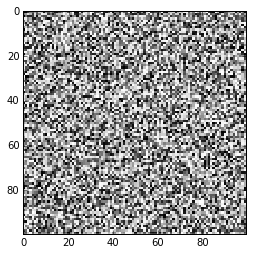

In [38]:
imgplot = plt.imshow(img, cm.Greys_r, interpolation='none')

In [39]:
dx, dt = 1,0.1

In [69]:
u = np.copy(img)

In [41]:
d = np.zeros((height, width))

In [45]:
def do_step(u):
    for i, u_x in np.ndenumerate(u):
        if i[0] - 1 < 0:
            left = 0
        else:
            left = u[(i[0]-1, i[1])]
        if i[0] + 1 > u.shape[1]-1:
            right = 0
        else:
            right = u[(i[0]+1, i[1])]
        if i[1] - 1 < 0:
            up = 0
        else:
            up = u[(i[0], i[1]-1)]
        if i[1] + 1 > u.shape[0]-1:
            down = 0
        else:
            down = u[(i[0], i[1]+1)]
        
        d[i] = up + down + left + right - (4 * u_x)
        d[i] *= dt
    u += d


In [43]:
def show(img):
    plt.imshow(img.reshape(height,width), cm.Greys_r, interpolation='none')

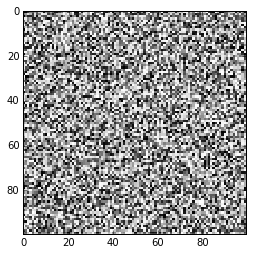

In [70]:
show(u)

In [63]:
for i in xrange(100): do_step(u)

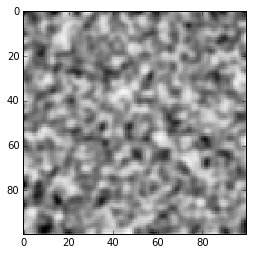

In [71]:
with_blur = ndimage.gaussian_filter(img, sigma=np.sqrt(2)); show(with_blur)